In [2]:
import sys
sys.path.append('../')

from quantumsim import *
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pympler import asizeof
import time
import networkx as nx

In [ ]:
params1 = {
        "sites": 3, 
        "hopping": 1.0,
        "potential": 0.0, 
        "pattern": "open"
        }

hubbard_chain1 = vqe_fermihubbard(params1)
hubbard_chain1.set_group_characteristics()
        
ansatz_params = {
            "repetitions": 1,
            "base": "default.qubit",
            "interface": "autograd",
            "electrons": params1["sites"],
            "qubits": hubbard_chain1.qubits,
        }

ansazt = upccgsd_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )
a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain1.qubits, delta_sz=0)

minimizate_params = {
                "type": "SLSQP",
                "maxiter": 100,
                "tol": 1e-6,
                "number":  a*b,
                "theta":["generic", 0.3]}

hubbard_chain1.node = ansazt.node
optimizer = gradiend_optimizer(minimizate_params)
energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)

In [2]:
def NH3positions(altura, bound):
    symbols = ["N", "H", "H", "H"]
    lado = np.sqrt(3)*np.sqrt(bound*bound - altura*altura)
    x = np.sqrt( bound*bound - altura*altura - lado*lado/4.0 )
    coordinates = np.array([0.0, 0.0, altura, lado/2, -x, 0.0, -lado/2, -x, 0.0, np.sqrt(bound*bound - altura*altura), 0.0])
    return symbols, coordinates

NH3positions(-2, 2.0)


(['N', 'H', 'H', 'H'],
 tensor([ 0.,  0., -2.,  0., -0.,  0., -0., -0.,  0.,  0.,  0.], requires_grad=True))

In [2]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, 0.86, 0.0, 0.0, -0.86])
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
}

system = adap_molecular(symbols, coordinates, params)
print(system.qubits)

4


In [3]:
ansatz_params = {
            "repetitions": 1,
            "base": "default.qubit",
            "interface": "autograd",
            "electrons": 2,
        }

system.set_device( ansatz_params )
system.set_node( ansatz_params )
system.set_state( ansatz_params["electrons"] )

In [5]:
minimizate_params = {
    "maxiter": 20,
    "qubits": system.qubits,
    "electrons": 2,
    "theta":["generic", 0.3]}

optimizer = adap_optimizer(minimizate_params)
energy1, optimum = optimizer.MinimumCircuit(system.node)

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('float64')) -> None

In [25]:
a = nx.grid_2d_graph(2, 3, False).edges()
print(a)

print("par")
for i in a:
    x,y = i
    print(2*3*x[0] + 2*x[1], 2*3*y[0] + 2*y[1])

print("impar")
for i in a:
    x,y = i
    print(2*3*x[0] + 2*x[1]+1, 2*3*y[0] + 2*y[1]+1)

[((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((1, 0), (1, 1)), ((1, 1), (1, 2))]
par
0 6
0 2
2 8
2 4
4 10
6 8
8 10
impar
1 7
1 3
3 9
3 5
5 11
7 9
9 11


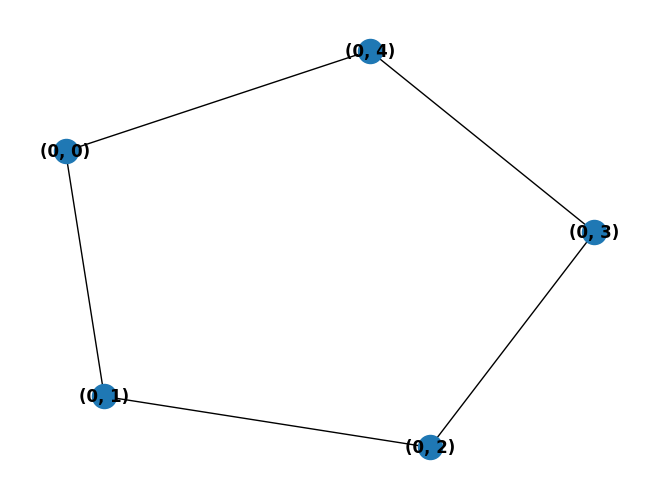

In [10]:
import matplotlib.pyplot as plt
nx.draw(nx.grid_2d_graph(1, 5, True), with_labels=True, font_weight='bold')

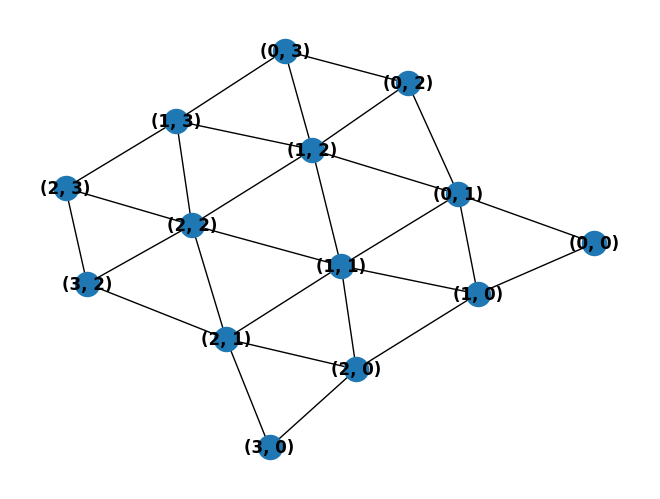

In [13]:
nx.draw(nx.triangular_lattice_graph(3, 5, False), with_labels=True, font_weight='bold')

In [7]:
nx.draw(nx.square_lattice_graph(3, 5, False), with_labels=False, font_weight='bold')

AttributeError: module 'networkx' has no attribute 'square_lattice_graph'

In [2]:
hopping = [1.0]
for j in range(1):
    print(j)
    for t in hopping:
        params1 = {
        "sites": 3, 
        "hopping": 1,
        "potential": t, 
        "pattern": "close"
        }

        hubbard_chain1 = vqe_fermihubbard(params1)
        
        ansatz_params = {
            "repetitions": 1,
            "base": "default.qubit",
            "interface": "autograd",
            "electrons": params1["sites"],
            "qubits": hubbard_chain1.qubits,
        }

        ansazt = uccds_ansatz()
        ansazt.set_device( ansatz_params )
        ansazt.set_node( ansatz_params )
        ansazt.set_state( ansatz_params["electrons"] )

        minimizate_params = {
                "type": "SLSQP",
                "maxiter": 60,
                "tol": 0.000001,
                "number":  len(ansazt.singles) + len(ansazt.doubles),
                "theta":["generic", 0.3]}

        hubbard_chain1.node = ansazt.node
        optimizer = gradiend_optimizer(minimizate_params)
        energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
        print( t, energy1[-1], len(energy1) )
        #valores_ucc.append(energy1[-1])

0
[tensor(0.50696213, requires_grad=True), tensor(0.00693627, requires_grad=True), tensor(0.00787649, requires_grad=True), tensor(0.00786936, requires_grad=True), tensor(0.00431824, requires_grad=True), tensor(0.00431824, requires_grad=True), tensor(0.00341216, requires_grad=True), tensor(0.2499072, requires_grad=True), tensor(0.25336015, requires_grad=True)]
[<autograd.numpy.numpy_boxes.ArrayBox object at 0x176ce3ac0>, <autograd.numpy.numpy_boxes.ArrayBox object at 0x176b359c0>, <autograd.numpy.numpy_boxes.ArrayBox object at 0x17687ec80>, <autograd.numpy.numpy_boxes.ArrayBox object at 0x176b19b80>, <autograd.numpy.numpy_boxes.ArrayBox object at 0x1767b4c00>, <autograd.numpy.numpy_boxes.ArrayBox object at 0x176796940>, <autograd.numpy.numpy_boxes.ArrayBox object at 0x280d95fc0>, <autograd.numpy.numpy_boxes.ArrayBox object at 0x177d96a80>, <autograd.numpy.numpy_boxes.ArrayBox object at 0x176ef8480>]
[tensor(0.3722141, requires_grad=True), tensor(-0.13810248, requires_grad=True), tensor(

### Memoria

In [ ]:
from pympler import asizeof

def MemoriaFH(params):
    qubits = params["sites"]*2
    hopping = params["hopping"]
    potential = params["potential"]
    fermi_sentence = 0.0
    fermi_hopping = 0.0
    fermi_potential = 0.0
    

    if params["sites"] == 1:
        fermi_sentence +=  potential*FermiC(0)*FermiA(0)*FermiC(1)*FermiA(1)
    else:
        for i in range(params["sites"]-1):
            if hopping != 0.0:
                fermi_hopping +=  FermiC(2*i)*FermiA(2*i +2) + FermiC(2*i +2)*FermiA(2*i)
                fermi_hopping +=  FermiC(2*i+1)*FermiA(2*i +3) + FermiC(2*i +3)*FermiA(2*i +1)  
            
        for i in range(params["sites"]):
            if potential != 0.0:
                fermi_potential += FermiC(2*i)*FermiA(2*i)*FermiC(2*i +1)*FermiA(2*i +1)

        if params["pattern"] == "close" and params["sites"] != 2:
            qsite = 2*(params["sites"]-1)
            fermi_hopping +=  FermiC(0)*FermiA(qsite) + FermiC(qsite)*FermiA(0)
            fermi_hopping +=  FermiC(1)*FermiA(qsite+1) + FermiC(qsite+1)*FermiA(1) 

    fermi_sentence = -hopping*fermi_hopping + potential*fermi_potential

    h = qml.jordan_wigner( fermi_sentence)
    return asizeof.asizeof(h)

In [ ]:
for i in range(1, 8):
    params1 = {
    "sites": i+1,
    "hopping": 1, 
    "potential": 2.0,
    "pattern": "close"
    }

    print( MemoriaFH(params1) )

In [ ]:
for i in range(1, 8):
    params1 = {
    "sites": i+1,
    "hopping": 1, 
    "potential": 2.0,
    "pattern": "close"
    }
    hubbard_chain1 = vqe_fermihubbard(params1)
    hubbard_chain1.set_group_characteristics()

    print( asizeof.asizeof(hubbard_chain1) )

### Barrido hopping

In [ ]:
hopping = np.linspace(-1.5, 1.5, 13)
valores_kup = []

for i in range(5):
    print(i+1)
    for t in hopping:
        if t == 0.0:
            pass
        else:
            params1 = {
            "sites": 5, 
            "hopping": t,
            "potential": 0.0, 
            "pattern": "open"
            }

            hubbard_chain1 = vqe_fermihubbard(params1)
            hubbard_chain1.set_group_characteristics()

            ansatz_params = {
                "repetitions": 1,
                "base": "default.qubit",
                "interface": "autograd",
                "electrons": params1["sites"],
                "qubits": hubbard_chain1.qubits,
            }
            ansazt = upccgsd_ansatz()
            ansazt.set_device( ansatz_params )
            ansazt.set_node( ansatz_params )
            ansazt.set_state( ansatz_params["electrons"] )
            a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain1.qubits, delta_sz=0)

            minimizate_params = {
                    "type": "SLSQP",
                    "maxiter": 100,
                    "tol": 1e-6,
                    "number":  a*b,
                    "theta":["generic", 0.3]}

            hubbard_chain1.node = ansazt.node
            optimizer = gradiend_optimizer(minimizate_params)
            energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
            print(t, energy1[-1], len(energy1))
            valores_kup.append(energy1[-1])

In [ ]:
hopping = np.linspace(-1.5, 1.5, 13)
valores_kup = []

for i in range(1):
    print(i+1)
    for t in hopping:
        if t == 0.0:
            pass
        else:
            params1 = {
            "sites": 6, 
            "hopping": t,
            "potential": 0.0, 
            "pattern": "open"
            }

            hubbard_chain1 = vqe_fermihubbard(params1)
            hubbard_chain1.set_group_characteristics()

            ansatz_params = {
                "repetitions": 1,
                "base": "default.qubit",
                "interface": "autograd",
                "electrons": params1["sites"],
                "qubits": hubbard_chain1.qubits,
            }
            ansazt = upccgsd_ansatz()
            ansazt.set_device( ansatz_params )
            ansazt.set_node( ansatz_params )
            ansazt.set_state( ansatz_params["electrons"] )
            a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain1.qubits, delta_sz=0)

            minimizate_params = {
                    "type": "SLSQP",
                    "maxiter": 100,
                    "tol": 1e-6,
                    "number":  a*b,
                    "theta":["generic", 0.3]}

            hubbard_chain1.node = ansazt.node
            optimizer = gradiend_optimizer(minimizate_params)
            energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
            print(t, energy1[-1], len(energy1))
            valores_kup.append(energy1[-1])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,4),)
ax.set_xlabel("Hopping", fontsize=13)
ax.set_ylabel("Energía", fontsize=13)

ax.plot(hopping, exacto, color="black", ls="dashed", label="Exacto")
ax.plot(hopping, valores_kup, marker='o', ls="dashed", label="k-UpCCGSD")
ax.plot(hopping, valores_ucc, marker='o', ls="dashed", label="UCCSD")

ax.legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

### Barrido theta

In [ ]:
params1 = {
    "sites": 3,  #Numero de sitios 2,4,6
    "hopping": 1.5, #Este hay que dejarlo fijo
    "potential": 0.0, #Este hay que variarlo
    "pattern": "open" #Este se puede variar <close> o <open>
}

hubbard_chain1 = vqe_fermihubbard(params1)
hubbard_chain1.set_group_characteristics()

ansatz_params = {
    "repetitions": 1,
    "base": "default.qubit",
    "interface": "autograd",
    "electrons": params1["sites"],
    "qubits": hubbard_chain1.qubits,
}

ansazt = upccgsd_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )
a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain1.qubits, delta_sz=0)

In [ ]:
theta = np.linspace(0.2, 0.5, 11)
valores = []
for t in theta:
    print(t)
    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", t]}

    hubbard_chain1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
    print( len(energy1) )
    valores.append(energy1)

In [ ]:
ee = FHExacto(params1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="theta"+str(np.round(theta[i],3)))
    ax[1].plot([j for j in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")

ax[0].plot([j for j in range( 40 ) ], [ee[0] for j in range(40)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=2)
fig.tight_layout()
plt.show()

### Open model

In [ ]:
params1 = {
    "sites": 4,  #Numero de sitios 2,4,6
    "hopping": 0.75, #Este hay que dejarlo fijo
    "potential": 0, #Este hay que variarlo
    "pattern": "close" #Este se puede variar <close> o <open>
}

hubbard_chain1 = vqe_fermihubbard(params1)
hubbard_chain1.set_group_characteristics()

In [ ]:
valores_kup = []
for k in range(1):
    print(k+1)
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": params1["sites"],
        "qubits": hubbard_chain1.qubits,
        "pattern": "chain"
    }

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain1.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    hubbard_chain1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
    valores_kup.append(energy1)

In [ ]:
valores_ucc = []
for k in range(1):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": params1["sites"],
        "qubits": hubbard_chain1.qubits,
        "pattern": "chain"
    }


    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    hubbard_chain1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
    valores_ucc.append(energy1)

In [ ]:
ee = FHExacto(params1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)

for i, val in enumerate(valores_kup):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k-UpCCGSD")
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed", label="k-UpCCGSD")

for i, val in enumerate(valores_ucc):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="UCCSD")
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed", label="UCCSD")

ax[0].plot([j for j in range( 40 ) ], [ee[0] for j in range(40)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=2)
fig.tight_layout()
plt.show()

### Tiempo

In [ ]:
params1 = {
    "sites": 4,  
    "hopping": 1.0, 
    "potential": 0.0, 
    "pattern": "open" 
}
hubbard_chain1 = vqe_fermihubbard(params1)
hubbard_chain1.set_group_characteristics()
print( len(hubbard_chain1.hamiltonian_object) )
ansatz_params = {
    "repetitions": 1,
    "base": "default.qubit",
    "interface": "autograd",
    "electrons": params1["sites"],
    "qubits": hubbard_chain1.qubits,
    "pattern": "chain"
}
ansazt = upccgsd_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )
a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=hubbard_chain1.qubits, delta_sz=0)

minimizate_params = {
    "type": "SLSQP",
    "maxiter": 60,
    "tol": 1e-6,
    "number":  a*b,
    "theta":["generic", 0.30]}

hubbard_chain1.node = ansazt.node

tiempo = []
for i in range(10):
    optimizer = gradiend_optimizer(minimizate_params)
    print(i+1)
    inicio = time.time()
    energy1, optimum = optimizer.VQE(hubbard_chain1.cost_function)
    final = time.time()

    tiempo.append(final-inicio)
    print(tiempo)

In [ ]:
tiempo

In [ ]:
def FHExacto_tiempo(params):
    qubits = params["sites"]*2
    hopping = params["hopping"]
    potential = params["potential"]
    fermi_sentence = 0.0
    fermi_hopping = 0.0
    fermi_potential = 0.0
    

    if params["sites"] == 1:
        fermi_sentence +=  potential*FermiC(0)*FermiA(0)*FermiC(1)*FermiA(1)
    else:
        for i in range(params["sites"]-1):
            if hopping != 0.0:
                fermi_hopping +=  FermiC(2*i)*FermiA(2*i +2) + FermiC(2*i +2)*FermiA(2*i)
                fermi_hopping +=  FermiC(2*i+1)*FermiA(2*i +3) + FermiC(2*i +3)*FermiA(2*i +1)  
            
        for i in range(params["sites"]):
            if potential != 0.0:
                fermi_potential += FermiC(2*i)*FermiA(2*i)*FermiC(2*i +1)*FermiA(2*i +1)

        if params["pattern"] == "close" and params["sites"] != 2:
            qsite = 2*(params["sites"]-1)
            fermi_hopping +=  FermiC(0)*FermiA(qsite) + FermiC(qsite)*FermiA(0)
            fermi_hopping +=  FermiC(1)*FermiA(qsite+1) + FermiC(qsite+1)*FermiA(1) 

    fermi_sentence = -hopping*fermi_hopping + potential*fermi_potential

    h = qml.jordan_wigner( fermi_sentence)
    h = h.sparse_matrix().toarray()
    inicio = time.time()
    val, vec = np.linalg.eigh(h)
    final = time.time()
    return final-inicio

In [ ]:
params1 = {
    "sites": 7,  
    "hopping": 1.5, 
    "potential": 0.0, 
    "pattern": "open" 
}

for i in range(10):
    print( FHExacto_tiempo(params1) )